Getting started

In [0]:
# Based on https://github.com/davidsandberg/facenet/wiki/Validate-on-lfw

# download facenet repo
!git clone https://github.com/davidsandberg/facenet.git
%cd facenet

# install packages
!pip install -r requirements.txt

# download Labelled Faces in the Wild test set
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz
!mv lfw.tgz data/
!mkdir data/lfw
!mkdir data/lfw/raw
!tar xvf data/lfw.tgz -C data/lfw/raw --strip-components=1
%set_env PYTHONPATH=/content/facenet/src
!mkdir data/lfw/lfw_mtcnnpy_160

Cloning into 'facenet'...
remote: Enumerating objects: 3149, done.
remote: Total 3149 (delta 0), reused 0 (delta 0), pack-reused 3149
Receiving objects: 100% (3149/3149), 2.94 MiB | 5.28 MiB/s, done.
Resolving deltas: 100% (2231/2231), done.
/content/facenet
     |████████████████████████████████| 48.0MB 200kB/s 
     |████████████████████████████████| 3.1MB 45.2MB/s 
     |████████████████████████████████| 890kB 46.8MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107221 sha256=df2a33789081bb0f735bac6d88d8a9be81c65b64ca1d6eab6377d1b92c9da904
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.7.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3

In [0]:
%pwd

'/content/facenet'

Slight modification to Facenet alignment code

In [0]:
%%writefile src/align/detect_face.py

""" Tensorflow implementation of the face detection / alignment algorithm found at
https://github.com/kpzhang93/MTCNN_face_detection_alignment
"""
# MIT License
# 
# Copyright (c) 2016 David Sandberg
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from six import string_types, iteritems

import numpy as np
import tensorflow as tf
#from math import floor
import cv2
import os

def layer(op):
    """Decorator for composable network layers."""

    def layer_decorated(self, *args, **kwargs):
        # Automatically set a name if not provided.
        name = kwargs.setdefault('name', self.get_unique_name(op.__name__))
        # Figure out the layer inputs.
        if len(self.terminals) == 0:
            raise RuntimeError('No input variables found for layer %s.' % name)
        elif len(self.terminals) == 1:
            layer_input = self.terminals[0]
        else:
            layer_input = list(self.terminals)
        # Perform the operation and get the output.
        layer_output = op(self, layer_input, *args, **kwargs)
        # Add to layer LUT.
        self.layers[name] = layer_output
        # This output is now the input for the next layer.
        self.feed(layer_output)
        # Return self for chained calls.
        return self

    return layer_decorated

class Network(object):

    def __init__(self, inputs, trainable=True):
        # The input nodes for this network
        self.inputs = inputs
        # The current list of terminal nodes
        self.terminals = []
        # Mapping from layer names to layers
        self.layers = dict(inputs)
        # If true, the resulting variables are set as trainable
        self.trainable = trainable

        self.setup()

    def setup(self):
        """Construct the network. """
        raise NotImplementedError('Must be implemented by the subclass.')

    def load(self, data_path, session, ignore_missing=False):
        """Load network weights.
        data_path: The path to the numpy-serialized network weights
        session: The current TensorFlow session
        ignore_missing: If true, serialized weights for missing layers are ignored.
        """
        data_dict = np.load(data_path, encoding='latin1', allow_pickle=True).item() #pylint: disable=no-member

        for op_name in data_dict:
            with tf.variable_scope(op_name, reuse=True):
                for param_name, data in iteritems(data_dict[op_name]):
                    try:
                        var = tf.get_variable(param_name)
                        session.run(var.assign(data))
                    except ValueError:
                        if not ignore_missing:
                            raise

    def feed(self, *args):
        """Set the input(s) for the next operation by replacing the terminal nodes.
        The arguments can be either layer names or the actual layers.
        """
        assert len(args) != 0
        self.terminals = []
        for fed_layer in args:
            if isinstance(fed_layer, string_types):
                try:
                    fed_layer = self.layers[fed_layer]
                except KeyError:
                    raise KeyError('Unknown layer name fed: %s' % fed_layer)
            self.terminals.append(fed_layer)
        return self

    def get_output(self):
        """Returns the current network output."""
        return self.terminals[-1]

    def get_unique_name(self, prefix):
        """Returns an index-suffixed unique name for the given prefix.
        This is used for auto-generating layer names based on the type-prefix.
        """
        ident = sum(t.startswith(prefix) for t, _ in self.layers.items()) + 1
        return '%s_%d' % (prefix, ident)

    def make_var(self, name, shape):
        """Creates a new TensorFlow variable."""
        return tf.get_variable(name, shape, trainable=self.trainable)

    def validate_padding(self, padding):
        """Verifies that the padding is one of the supported ones."""
        assert padding in ('SAME', 'VALID')

    @layer
    def conv(self,
             inp,
             k_h,
             k_w,
             c_o,
             s_h,
             s_w,
             name,
             relu=True,
             padding='SAME',
             group=1,
             biased=True):
        # Verify that the padding is acceptable
        self.validate_padding(padding)
        # Get the number of channels in the input
        c_i = int(inp.get_shape()[-1])
        # Verify that the grouping parameter is valid
        assert c_i % group == 0
        assert c_o % group == 0
        # Convolution for a given input and kernel
        convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
        with tf.variable_scope(name) as scope:
            kernel = self.make_var('weights', shape=[k_h, k_w, c_i // group, c_o])
            # This is the common-case. Convolve the input without any further complications.
            output = convolve(inp, kernel)
            # Add the biases
            if biased:
                biases = self.make_var('biases', [c_o])
                output = tf.nn.bias_add(output, biases)
            if relu:
                # ReLU non-linearity
                output = tf.nn.relu(output, name=scope.name)
            return output

    @layer
    def prelu(self, inp, name):
        with tf.variable_scope(name):
            i = int(inp.get_shape()[-1])
            alpha = self.make_var('alpha', shape=(i,))
            output = tf.nn.relu(inp) + tf.multiply(alpha, -tf.nn.relu(-inp))
        return output

    @layer
    def max_pool(self, inp, k_h, k_w, s_h, s_w, name, padding='SAME'):
        self.validate_padding(padding)
        return tf.nn.max_pool(inp,
                              ksize=[1, k_h, k_w, 1],
                              strides=[1, s_h, s_w, 1],
                              padding=padding,
                              name=name)

    @layer
    def fc(self, inp, num_out, name, relu=True):
        with tf.variable_scope(name):
            input_shape = inp.get_shape()
            if input_shape.ndims == 4:
                # The input is spatial. Vectorize it first.
                dim = 1
                for d in input_shape[1:].as_list():
                    dim *= int(d)
                feed_in = tf.reshape(inp, [-1, dim])
            else:
                feed_in, dim = (inp, input_shape[-1].value)
            weights = self.make_var('weights', shape=[dim, num_out])
            biases = self.make_var('biases', [num_out])
            op = tf.nn.relu_layer if relu else tf.nn.xw_plus_b
            fc = op(feed_in, weights, biases, name=name)
            return fc


    """
    Multi dimensional softmax,
    refer to https://github.com/tensorflow/tensorflow/issues/210
    compute softmax along the dimension of target
    the native softmax only supports batch_size x dimension
    """
    @layer
    def softmax(self, target, axis, name=None):
        max_axis = tf.reduce_max(target, axis, keepdims=True)
        target_exp = tf.exp(target-max_axis)
        normalize = tf.reduce_sum(target_exp, axis, keepdims=True)
        softmax = tf.div(target_exp, normalize, name)
        return softmax
    
class PNet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 10, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='PReLU1')
             .max_pool(2, 2, 2, 2, name='pool1')
             .conv(3, 3, 16, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='PReLU2')
             .conv(3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='PReLU3')
             .conv(1, 1, 2, 1, 1, relu=False, name='conv4-1')
             .softmax(3,name='prob1'))

        (self.feed('PReLU3') #pylint: disable=no-value-for-parameter
             .conv(1, 1, 4, 1, 1, relu=False, name='conv4-2'))
        
class RNet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 28, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='prelu1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(3, 3, 48, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='prelu2')
             .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
             .conv(2, 2, 64, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='prelu3')
             .fc(128, relu=False, name='conv4')
             .prelu(name='prelu4')
             .fc(2, relu=False, name='conv5-1')
             .softmax(1,name='prob1'))

        (self.feed('prelu4') #pylint: disable=no-value-for-parameter
             .fc(4, relu=False, name='conv5-2'))

class ONet(Network):
    def setup(self):
        (self.feed('data') #pylint: disable=no-value-for-parameter, no-member
             .conv(3, 3, 32, 1, 1, padding='VALID', relu=False, name='conv1')
             .prelu(name='prelu1')
             .max_pool(3, 3, 2, 2, name='pool1')
             .conv(3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv2')
             .prelu(name='prelu2')
             .max_pool(3, 3, 2, 2, padding='VALID', name='pool2')
             .conv(3, 3, 64, 1, 1, padding='VALID', relu=False, name='conv3')
             .prelu(name='prelu3')
             .max_pool(2, 2, 2, 2, name='pool3')
             .conv(2, 2, 128, 1, 1, padding='VALID', relu=False, name='conv4')
             .prelu(name='prelu4')
             .fc(256, relu=False, name='conv5')
             .prelu(name='prelu5')
             .fc(2, relu=False, name='conv6-1')
             .softmax(1, name='prob1'))

        (self.feed('prelu5') #pylint: disable=no-value-for-parameter
             .fc(4, relu=False, name='conv6-2'))

        (self.feed('prelu5') #pylint: disable=no-value-for-parameter
             .fc(10, relu=False, name='conv6-3'))

def create_mtcnn(sess, model_path):
    if not model_path:
        model_path,_ = os.path.split(os.path.realpath(__file__))

    with tf.variable_scope('pnet'):
        data = tf.placeholder(tf.float32, (None,None,None,3), 'input')
        pnet = PNet({'data':data})
        pnet.load(os.path.join(model_path, 'det1.npy'), sess)
    with tf.variable_scope('rnet'):
        data = tf.placeholder(tf.float32, (None,24,24,3), 'input')
        rnet = RNet({'data':data})
        rnet.load(os.path.join(model_path, 'det2.npy'), sess)
    with tf.variable_scope('onet'):
        data = tf.placeholder(tf.float32, (None,48,48,3), 'input')
        onet = ONet({'data':data})
        onet.load(os.path.join(model_path, 'det3.npy'), sess)
        
    pnet_fun = lambda img : sess.run(('pnet/conv4-2/BiasAdd:0', 'pnet/prob1:0'), feed_dict={'pnet/input:0':img})
    rnet_fun = lambda img : sess.run(('rnet/conv5-2/conv5-2:0', 'rnet/prob1:0'), feed_dict={'rnet/input:0':img})
    onet_fun = lambda img : sess.run(('onet/conv6-2/conv6-2:0', 'onet/conv6-3/conv6-3:0', 'onet/prob1:0'), feed_dict={'onet/input:0':img})
    return pnet_fun, rnet_fun, onet_fun

def detect_face(img, minsize, pnet, rnet, onet, threshold, factor):
    """Detects faces in an image, and returns bounding boxes and points for them.
    img: input image
    minsize: minimum faces' size
    pnet, rnet, onet: caffemodel
    threshold: threshold=[th1, th2, th3], th1-3 are three steps's threshold
    factor: the factor used to create a scaling pyramid of face sizes to detect in the image.
    """
    factor_count=0
    total_boxes=np.empty((0,9))
    points=np.empty(0)
    h=img.shape[0]
    w=img.shape[1]
    minl=np.amin([h, w])
    m=12.0/minsize
    minl=minl*m
    # create scale pyramid
    scales=[]
    while minl>=12:
        scales += [m*np.power(factor, factor_count)]
        minl = minl*factor
        factor_count += 1

    # first stage
    for scale in scales:
        hs=int(np.ceil(h*scale))
        ws=int(np.ceil(w*scale))
        im_data = imresample(img, (hs, ws))
        im_data = (im_data-127.5)*0.0078125
        img_x = np.expand_dims(im_data, 0)
        img_y = np.transpose(img_x, (0,2,1,3))
        out = pnet(img_y)
        out0 = np.transpose(out[0], (0,2,1,3))
        out1 = np.transpose(out[1], (0,2,1,3))
        
        boxes, _ = generateBoundingBox(out1[0,:,:,1].copy(), out0[0,:,:,:].copy(), scale, threshold[0])
        
        # inter-scale nms
        pick = nms(boxes.copy(), 0.5, 'Union')
        if boxes.size>0 and pick.size>0:
            boxes = boxes[pick,:]
            total_boxes = np.append(total_boxes, boxes, axis=0)

    numbox = total_boxes.shape[0]
    if numbox>0:
        pick = nms(total_boxes.copy(), 0.7, 'Union')
        total_boxes = total_boxes[pick,:]
        regw = total_boxes[:,2]-total_boxes[:,0]
        regh = total_boxes[:,3]-total_boxes[:,1]
        qq1 = total_boxes[:,0]+total_boxes[:,5]*regw
        qq2 = total_boxes[:,1]+total_boxes[:,6]*regh
        qq3 = total_boxes[:,2]+total_boxes[:,7]*regw
        qq4 = total_boxes[:,3]+total_boxes[:,8]*regh
        total_boxes = np.transpose(np.vstack([qq1, qq2, qq3, qq4, total_boxes[:,4]]))
        total_boxes = rerec(total_boxes.copy())
        total_boxes[:,0:4] = np.fix(total_boxes[:,0:4]).astype(np.int32)
        dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)

    numbox = total_boxes.shape[0]
    if numbox>0:
        # second stage
        tempimg = np.zeros((24,24,3,numbox))
        for k in range(0,numbox):
            tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
            tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
            if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
                tempimg[:,:,:,k] = imresample(tmp, (24, 24))
            else:
                return np.empty()
        tempimg = (tempimg-127.5)*0.0078125
        tempimg1 = np.transpose(tempimg, (3,1,0,2))
        out = rnet(tempimg1)
        out0 = np.transpose(out[0])
        out1 = np.transpose(out[1])
        score = out1[1,:]
        ipass = np.where(score>threshold[1])
        total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
        mv = out0[:,ipass[0]]
        if total_boxes.shape[0]>0:
            pick = nms(total_boxes, 0.7, 'Union')
            total_boxes = total_boxes[pick,:]
            total_boxes = bbreg(total_boxes.copy(), np.transpose(mv[:,pick]))
            total_boxes = rerec(total_boxes.copy())

    numbox = total_boxes.shape[0]
    if numbox>0:
        # third stage
        total_boxes = np.fix(total_boxes).astype(np.int32)
        dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(total_boxes.copy(), w, h)
        tempimg = np.zeros((48,48,3,numbox))
        for k in range(0,numbox):
            tmp = np.zeros((int(tmph[k]),int(tmpw[k]),3))
            tmp[dy[k]-1:edy[k],dx[k]-1:edx[k],:] = img[y[k]-1:ey[k],x[k]-1:ex[k],:]
            if tmp.shape[0]>0 and tmp.shape[1]>0 or tmp.shape[0]==0 and tmp.shape[1]==0:
                tempimg[:,:,:,k] = imresample(tmp, (48, 48))
            else:
                return np.empty()
        tempimg = (tempimg-127.5)*0.0078125
        tempimg1 = np.transpose(tempimg, (3,1,0,2))
        out = onet(tempimg1)
        out0 = np.transpose(out[0])
        out1 = np.transpose(out[1])
        out2 = np.transpose(out[2])
        score = out2[1,:]
        points = out1
        ipass = np.where(score>threshold[2])
        points = points[:,ipass[0]]
        total_boxes = np.hstack([total_boxes[ipass[0],0:4].copy(), np.expand_dims(score[ipass].copy(),1)])
        mv = out0[:,ipass[0]]

        w = total_boxes[:,2]-total_boxes[:,0]+1
        h = total_boxes[:,3]-total_boxes[:,1]+1
        points[0:5,:] = np.tile(w,(5, 1))*points[0:5,:] + np.tile(total_boxes[:,0],(5, 1))-1
        points[5:10,:] = np.tile(h,(5, 1))*points[5:10,:] + np.tile(total_boxes[:,1],(5, 1))-1
        if total_boxes.shape[0]>0:
            total_boxes = bbreg(total_boxes.copy(), np.transpose(mv))
            pick = nms(total_boxes.copy(), 0.7, 'Min')
            total_boxes = total_boxes[pick,:]
            points = points[:,pick]
                
    return total_boxes, points


def bulk_detect_face(images, detection_window_size_ratio, pnet, rnet, onet, threshold, factor):
    """Detects faces in a list of images
    images: list containing input images
    detection_window_size_ratio: ratio of minimum face size to smallest image dimension
    pnet, rnet, onet: caffemodel
    threshold: threshold=[th1 th2 th3], th1-3 are three steps's threshold [0-1]
    factor: the factor used to create a scaling pyramid of face sizes to detect in the image.
    """
    all_scales = [None] * len(images)
    images_with_boxes = [None] * len(images)

    for i in range(len(images)):
        images_with_boxes[i] = {'total_boxes': np.empty((0, 9))}

    # create scale pyramid
    for index, img in enumerate(images):
        all_scales[index] = []
        h = img.shape[0]
        w = img.shape[1]
        minsize = int(detection_window_size_ratio * np.minimum(w, h))
        factor_count = 0
        minl = np.amin([h, w])
        if minsize <= 12:
            minsize = 12

        m = 12.0 / minsize
        minl = minl * m
        while minl >= 12:
            all_scales[index].append(m * np.power(factor, factor_count))
            minl = minl * factor
            factor_count += 1

    # # # # # # # # # # # # #
    # first stage - fast proposal network (pnet) to obtain face candidates
    # # # # # # # # # # # # #

    images_obj_per_resolution = {}

    # TODO: use some type of rounding to number module 8 to increase probability that pyramid images will have the same resolution across input images

    for index, scales in enumerate(all_scales):
        h = images[index].shape[0]
        w = images[index].shape[1]

        for scale in scales:
            hs = int(np.ceil(h * scale))
            ws = int(np.ceil(w * scale))

            if (ws, hs) not in images_obj_per_resolution:
                images_obj_per_resolution[(ws, hs)] = []

            im_data = imresample(images[index], (hs, ws))
            im_data = (im_data - 127.5) * 0.0078125
            img_y = np.transpose(im_data, (1, 0, 2))  # caffe uses different dimensions ordering
            images_obj_per_resolution[(ws, hs)].append({'scale': scale, 'image': img_y, 'index': index})

    for resolution in images_obj_per_resolution:
        images_per_resolution = [i['image'] for i in images_obj_per_resolution[resolution]]
        outs = pnet(images_per_resolution)

        for index in range(len(outs[0])):
            scale = images_obj_per_resolution[resolution][index]['scale']
            image_index = images_obj_per_resolution[resolution][index]['index']
            out0 = np.transpose(outs[0][index], (1, 0, 2))
            out1 = np.transpose(outs[1][index], (1, 0, 2))

            boxes, _ = generateBoundingBox(out1[:, :, 1].copy(), out0[:, :, :].copy(), scale, threshold[0])

            # inter-scale nms
            pick = nms(boxes.copy(), 0.5, 'Union')
            if boxes.size > 0 and pick.size > 0:
                boxes = boxes[pick, :]
                images_with_boxes[image_index]['total_boxes'] = np.append(images_with_boxes[image_index]['total_boxes'],
                                                                          boxes,
                                                                          axis=0)

    for index, image_obj in enumerate(images_with_boxes):
        numbox = image_obj['total_boxes'].shape[0]
        if numbox > 0:
            h = images[index].shape[0]
            w = images[index].shape[1]
            pick = nms(image_obj['total_boxes'].copy(), 0.7, 'Union')
            image_obj['total_boxes'] = image_obj['total_boxes'][pick, :]
            regw = image_obj['total_boxes'][:, 2] - image_obj['total_boxes'][:, 0]
            regh = image_obj['total_boxes'][:, 3] - image_obj['total_boxes'][:, 1]
            qq1 = image_obj['total_boxes'][:, 0] + image_obj['total_boxes'][:, 5] * regw
            qq2 = image_obj['total_boxes'][:, 1] + image_obj['total_boxes'][:, 6] * regh
            qq3 = image_obj['total_boxes'][:, 2] + image_obj['total_boxes'][:, 7] * regw
            qq4 = image_obj['total_boxes'][:, 3] + image_obj['total_boxes'][:, 8] * regh
            image_obj['total_boxes'] = np.transpose(np.vstack([qq1, qq2, qq3, qq4, image_obj['total_boxes'][:, 4]]))
            image_obj['total_boxes'] = rerec(image_obj['total_boxes'].copy())
            image_obj['total_boxes'][:, 0:4] = np.fix(image_obj['total_boxes'][:, 0:4]).astype(np.int32)
            dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(image_obj['total_boxes'].copy(), w, h)

            numbox = image_obj['total_boxes'].shape[0]
            tempimg = np.zeros((24, 24, 3, numbox))

            if numbox > 0:
                for k in range(0, numbox):
                    tmp = np.zeros((int(tmph[k]), int(tmpw[k]), 3))
                    tmp[dy[k] - 1:edy[k], dx[k] - 1:edx[k], :] = images[index][y[k] - 1:ey[k], x[k] - 1:ex[k], :]
                    if tmp.shape[0] > 0 and tmp.shape[1] > 0 or tmp.shape[0] == 0 and tmp.shape[1] == 0:
                        tempimg[:, :, :, k] = imresample(tmp, (24, 24))
                    else:
                        return np.empty()

                tempimg = (tempimg - 127.5) * 0.0078125
                image_obj['rnet_input'] = np.transpose(tempimg, (3, 1, 0, 2))

    # # # # # # # # # # # # #
    # second stage - refinement of face candidates with rnet
    # # # # # # # # # # # # #

    bulk_rnet_input = np.empty((0, 24, 24, 3))
    for index, image_obj in enumerate(images_with_boxes):
        if 'rnet_input' in image_obj:
            bulk_rnet_input = np.append(bulk_rnet_input, image_obj['rnet_input'], axis=0)

    out = rnet(bulk_rnet_input)
    out0 = np.transpose(out[0])
    out1 = np.transpose(out[1])
    score = out1[1, :]

    i = 0
    for index, image_obj in enumerate(images_with_boxes):
        if 'rnet_input' not in image_obj:
            continue

        rnet_input_count = image_obj['rnet_input'].shape[0]
        score_per_image = score[i:i + rnet_input_count]
        out0_per_image = out0[:, i:i + rnet_input_count]

        ipass = np.where(score_per_image > threshold[1])
        image_obj['total_boxes'] = np.hstack([image_obj['total_boxes'][ipass[0], 0:4].copy(),
                                              np.expand_dims(score_per_image[ipass].copy(), 1)])

        mv = out0_per_image[:, ipass[0]]

        if image_obj['total_boxes'].shape[0] > 0:
            h = images[index].shape[0]
            w = images[index].shape[1]
            pick = nms(image_obj['total_boxes'], 0.7, 'Union')
            image_obj['total_boxes'] = image_obj['total_boxes'][pick, :]
            image_obj['total_boxes'] = bbreg(image_obj['total_boxes'].copy(), np.transpose(mv[:, pick]))
            image_obj['total_boxes'] = rerec(image_obj['total_boxes'].copy())

            numbox = image_obj['total_boxes'].shape[0]

            if numbox > 0:
                tempimg = np.zeros((48, 48, 3, numbox))
                image_obj['total_boxes'] = np.fix(image_obj['total_boxes']).astype(np.int32)
                dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph = pad(image_obj['total_boxes'].copy(), w, h)

                for k in range(0, numbox):
                    tmp = np.zeros((int(tmph[k]), int(tmpw[k]), 3))
                    tmp[dy[k] - 1:edy[k], dx[k] - 1:edx[k], :] = images[index][y[k] - 1:ey[k], x[k] - 1:ex[k], :]
                    if tmp.shape[0] > 0 and tmp.shape[1] > 0 or tmp.shape[0] == 0 and tmp.shape[1] == 0:
                        tempimg[:, :, :, k] = imresample(tmp, (48, 48))
                    else:
                        return np.empty()
                tempimg = (tempimg - 127.5) * 0.0078125
                image_obj['onet_input'] = np.transpose(tempimg, (3, 1, 0, 2))

        i += rnet_input_count

    # # # # # # # # # # # # #
    # third stage - further refinement and facial landmarks positions with onet
    # # # # # # # # # # # # #

    bulk_onet_input = np.empty((0, 48, 48, 3))
    for index, image_obj in enumerate(images_with_boxes):
        if 'onet_input' in image_obj:
            bulk_onet_input = np.append(bulk_onet_input, image_obj['onet_input'], axis=0)

    out = onet(bulk_onet_input)

    out0 = np.transpose(out[0])
    out1 = np.transpose(out[1])
    out2 = np.transpose(out[2])
    score = out2[1, :]
    points = out1

    i = 0
    ret = []
    for index, image_obj in enumerate(images_with_boxes):
        if 'onet_input' not in image_obj:
            ret.append(None)
            continue

        onet_input_count = image_obj['onet_input'].shape[0]

        out0_per_image = out0[:, i:i + onet_input_count]
        score_per_image = score[i:i + onet_input_count]
        points_per_image = points[:, i:i + onet_input_count]

        ipass = np.where(score_per_image > threshold[2])
        points_per_image = points_per_image[:, ipass[0]]

        image_obj['total_boxes'] = np.hstack([image_obj['total_boxes'][ipass[0], 0:4].copy(),
                                              np.expand_dims(score_per_image[ipass].copy(), 1)])
        mv = out0_per_image[:, ipass[0]]

        w = image_obj['total_boxes'][:, 2] - image_obj['total_boxes'][:, 0] + 1
        h = image_obj['total_boxes'][:, 3] - image_obj['total_boxes'][:, 1] + 1
        points_per_image[0:5, :] = np.tile(w, (5, 1)) * points_per_image[0:5, :] + np.tile(
            image_obj['total_boxes'][:, 0], (5, 1)) - 1
        points_per_image[5:10, :] = np.tile(h, (5, 1)) * points_per_image[5:10, :] + np.tile(
            image_obj['total_boxes'][:, 1], (5, 1)) - 1

        if image_obj['total_boxes'].shape[0] > 0:
            image_obj['total_boxes'] = bbreg(image_obj['total_boxes'].copy(), np.transpose(mv))
            pick = nms(image_obj['total_boxes'].copy(), 0.7, 'Min')
            image_obj['total_boxes'] = image_obj['total_boxes'][pick, :]
            points_per_image = points_per_image[:, pick]

            ret.append((image_obj['total_boxes'], points_per_image))
        else:
            ret.append(None)

        i += onet_input_count

    return ret


# function [boundingbox] = bbreg(boundingbox,reg)
def bbreg(boundingbox,reg):
    """Calibrate bounding boxes"""
    if reg.shape[1]==1:
        reg = np.reshape(reg, (reg.shape[2], reg.shape[3]))

    w = boundingbox[:,2]-boundingbox[:,0]+1
    h = boundingbox[:,3]-boundingbox[:,1]+1
    b1 = boundingbox[:,0]+reg[:,0]*w
    b2 = boundingbox[:,1]+reg[:,1]*h
    b3 = boundingbox[:,2]+reg[:,2]*w
    b4 = boundingbox[:,3]+reg[:,3]*h
    boundingbox[:,0:4] = np.transpose(np.vstack([b1, b2, b3, b4 ]))
    return boundingbox
 
def generateBoundingBox(imap, reg, scale, t):
    """Use heatmap to generate bounding boxes"""
    stride=2
    cellsize=12

    imap = np.transpose(imap)
    dx1 = np.transpose(reg[:,:,0])
    dy1 = np.transpose(reg[:,:,1])
    dx2 = np.transpose(reg[:,:,2])
    dy2 = np.transpose(reg[:,:,3])
    y, x = np.where(imap >= t)
    if y.shape[0]==1:
        dx1 = np.flipud(dx1)
        dy1 = np.flipud(dy1)
        dx2 = np.flipud(dx2)
        dy2 = np.flipud(dy2)
    score = imap[(y,x)]
    reg = np.transpose(np.vstack([ dx1[(y,x)], dy1[(y,x)], dx2[(y,x)], dy2[(y,x)] ]))
    if reg.size==0:
        reg = np.empty((0,3))
    bb = np.transpose(np.vstack([y,x]))
    q1 = np.fix((stride*bb+1)/scale)
    q2 = np.fix((stride*bb+cellsize-1+1)/scale)
    boundingbox = np.hstack([q1, q2, np.expand_dims(score,1), reg])
    return boundingbox, reg
 
# function pick = nms(boxes,threshold,type)
def nms(boxes, threshold, method):
    if boxes.size==0:
        return np.empty((0,3))
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    s = boxes[:,4]
    area = (x2-x1+1) * (y2-y1+1)
    I = np.argsort(s)
    pick = np.zeros_like(s, dtype=np.int16)
    counter = 0
    while I.size>0:
        i = I[-1]
        pick[counter] = i
        counter += 1
        idx = I[0:-1]
        xx1 = np.maximum(x1[i], x1[idx])
        yy1 = np.maximum(y1[i], y1[idx])
        xx2 = np.minimum(x2[i], x2[idx])
        yy2 = np.minimum(y2[i], y2[idx])
        w = np.maximum(0.0, xx2-xx1+1)
        h = np.maximum(0.0, yy2-yy1+1)
        inter = w * h
        if method is 'Min':
            o = inter / np.minimum(area[i], area[idx])
        else:
            o = inter / (area[i] + area[idx] - inter)
        I = I[np.where(o<=threshold)]
    pick = pick[0:counter]
    return pick

# function [dy edy dx edx y ey x ex tmpw tmph] = pad(total_boxes,w,h)
def pad(total_boxes, w, h):
    """Compute the padding coordinates (pad the bounding boxes to square)"""
    tmpw = (total_boxes[:,2]-total_boxes[:,0]+1).astype(np.int32)
    tmph = (total_boxes[:,3]-total_boxes[:,1]+1).astype(np.int32)
    numbox = total_boxes.shape[0]

    dx = np.ones((numbox), dtype=np.int32)
    dy = np.ones((numbox), dtype=np.int32)
    edx = tmpw.copy().astype(np.int32)
    edy = tmph.copy().astype(np.int32)

    x = total_boxes[:,0].copy().astype(np.int32)
    y = total_boxes[:,1].copy().astype(np.int32)
    ex = total_boxes[:,2].copy().astype(np.int32)
    ey = total_boxes[:,3].copy().astype(np.int32)

    tmp = np.where(ex>w)
    edx.flat[tmp] = np.expand_dims(-ex[tmp]+w+tmpw[tmp],1)
    ex[tmp] = w
    
    tmp = np.where(ey>h)
    edy.flat[tmp] = np.expand_dims(-ey[tmp]+h+tmph[tmp],1)
    ey[tmp] = h

    tmp = np.where(x<1)
    dx.flat[tmp] = np.expand_dims(2-x[tmp],1)
    x[tmp] = 1

    tmp = np.where(y<1)
    dy.flat[tmp] = np.expand_dims(2-y[tmp],1)
    y[tmp] = 1
    
    return dy, edy, dx, edx, y, ey, x, ex, tmpw, tmph

# function [bboxA] = rerec(bboxA)
def rerec(bboxA):
    """Convert bboxA to square."""
    h = bboxA[:,3]-bboxA[:,1]
    w = bboxA[:,2]-bboxA[:,0]
    l = np.maximum(w, h)
    bboxA[:,0] = bboxA[:,0]+w*0.5-l*0.5
    bboxA[:,1] = bboxA[:,1]+h*0.5-l*0.5
    bboxA[:,2:4] = bboxA[:,0:2] + np.transpose(np.tile(l,(2,1)))
    return bboxA

def imresample(img, sz):
    im_data = cv2.resize(img, (sz[1], sz[0]), interpolation=cv2.INTER_AREA) #@UndefinedVariable
    return im_data

    # This method is kept for debugging purpose
#     h=img.shape[0]
#     w=img.shape[1]
#     hs, ws = sz
#     dx = float(w) / ws
#     dy = float(h) / hs
#     im_data = np.zeros((hs,ws,3))
#     for a1 in range(0,hs):
#         for a2 in range(0,ws):
#             for a3 in range(0,3):
#                 im_data[a1,a2,a3] = img[int(floor(a1*dy)),int(floor(a2*dx)),a3]
#     return im_data

Overwriting src/align/detect_face.py


Aligning LFW dataset

In [0]:
# ONLY DO THIS IN VM - risk of remote code execution attack 
# should take 10-15 minutes on colab GPU
!for N in {1..4}; do \
python src/align/align_dataset_mtcnn.py \
data/lfw/raw \
data/lfw/lfw_mtcnnpy_160 \
--image_size 160 \
--margin 32 \
--random_order \
--gpu_memory_fraction 0.25 \
& done

Creating networks and loading parameters
Creating networks and loading parameters
W1104 02:46:41.748780 140530957260672 module_wrapper.py:139] From src/align/align_dataset_mtcnn.py:52: The name tf.GPUOptions is deprecated. Please use tf.compat.v1.GPUOptions instead.

W1104 02:46:41.749341 140530957260672 module_wrapper.py:139] From src/align/align_dataset_mtcnn.py:53: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W1104 02:46:41.749659 140530957260672 module_wrapper.py:139] From src/align/align_dataset_mtcnn.py:53: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1104 02:46:41.750942 139699107690368 module_wrapper.py:139] From src/align/align_dataset_mtcnn.py:52: The name tf.GPUOptions is deprecated. Please use tf.compat.v1.GPUOptions instead.

W1104 02:46:41.751524 139699107690368 module_wrapper.py:139] From src/align/align_dataset_mtcnn.py:53: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

Download pre-trained model 

In [0]:
!pip install gdown
!gdown "https://drive.google.com/uc?id=1EXPBSXwTaqrSC0OhUdXNmKSh9qJUQ55-"
!mkdir models
!mv 20180402-114759.zip models/
!unzip models/20180402-114759.zip -d models

Downloading...
From: https://drive.google.com/uc?id=1EXPBSXwTaqrSC0OhUdXNmKSh9qJUQ55-
To: /content/facenet/20180402-114759.zip
192MB [00:02, 88.6MB/s]
Archive:  models/20180402-114759.zip
   creating: models/20180402-114759/
  inflating: models/20180402-114759/model-20180402-114759.meta  
  inflating: models/20180402-114759/20180402-114759.pb  
  inflating: models/20180402-114759/model-20180402-114759.ckpt-275.data-00000-of-00001  
  inflating: models/20180402-114759/model-20180402-114759.ckpt-275.index  


Fix facenet.py deprecated calls

In [0]:
%%writefile src/facenet.py

"""Functions for building the face recognition network.
"""
# MIT License
# 
# Copyright (c) 2016 David Sandberg
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# pylint: disable=missing-docstring
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from subprocess import Popen, PIPE
import tensorflow as tf
import numpy as np
from scipy import misc
from sklearn.model_selection import KFold
from scipy import interpolate
from tensorflow.python.training import training
import random
import re
from tensorflow.python.platform import gfile
import math
from six import iteritems
from matplotlib.pyplot import imread

def triplet_loss(anchor, positive, negative, alpha):
    """Calculate the triplet loss according to the FaceNet paper
    
    Args:
      anchor: the embeddings for the anchor images.
      positive: the embeddings for the positive images.
      negative: the embeddings for the negative images.
  
    Returns:
      the triplet loss according to the FaceNet paper as a float tensor.
    """
    with tf.variable_scope('triplet_loss'):
        pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), 1)
        neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), 1)
        
        basic_loss = tf.add(tf.subtract(pos_dist,neg_dist), alpha)
        loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), 0)
      
    return loss
  
def center_loss(features, label, alfa, nrof_classes):
    """Center loss based on the paper "A Discriminative Feature Learning Approach for Deep Face Recognition"
       (http://ydwen.github.io/papers/WenECCV16.pdf)
    """
    nrof_features = features.get_shape()[1]
    centers = tf.get_variable('centers', [nrof_classes, nrof_features], dtype=tf.float32,
        initializer=tf.constant_initializer(0), trainable=False)
    label = tf.reshape(label, [-1])
    centers_batch = tf.gather(centers, label)
    diff = (1 - alfa) * (centers_batch - features)
    centers = tf.scatter_sub(centers, label, diff)
    with tf.control_dependencies([centers]):
        loss = tf.reduce_mean(tf.square(features - centers_batch))
    return loss, centers

def get_image_paths_and_labels(dataset):
    image_paths_flat = []
    labels_flat = []
    for i in range(len(dataset)):
        image_paths_flat += dataset[i].image_paths
        labels_flat += [i] * len(dataset[i].image_paths)
    return image_paths_flat, labels_flat

def shuffle_examples(image_paths, labels):
    shuffle_list = list(zip(image_paths, labels))
    random.shuffle(shuffle_list)
    image_paths_shuff, labels_shuff = zip(*shuffle_list)
    return image_paths_shuff, labels_shuff

def random_rotate_image(image):
    angle = np.random.uniform(low=-10.0, high=10.0)
    return misc.imrotate(image, angle, 'bicubic')
  
# 1: Random rotate 2: Random crop  4: Random flip  8:  Fixed image standardization  16: Flip
RANDOM_ROTATE = 1
RANDOM_CROP = 2
RANDOM_FLIP = 4
FIXED_STANDARDIZATION = 8
FLIP = 16
def create_input_pipeline(input_queue, image_size, nrof_preprocess_threads, batch_size_placeholder):
    images_and_labels_list = []
    for _ in range(nrof_preprocess_threads):
        filenames, label, control = input_queue.dequeue()
        images = []
        for filename in tf.unstack(filenames):
            file_contents = tf.read_file(filename)
            image = tf.image.decode_image(file_contents, 3)
            image = tf.cond(get_control_flag(control[0], RANDOM_ROTATE),
                            lambda:tf.py_func(random_rotate_image, [image], tf.uint8), 
                            lambda:tf.identity(image))
            image = tf.cond(get_control_flag(control[0], RANDOM_CROP), 
                            lambda:tf.random_crop(image, image_size + (3,)), 
                            lambda:tf.image.resize_image_with_crop_or_pad(image, image_size[0], image_size[1]))
            image = tf.cond(get_control_flag(control[0], RANDOM_FLIP),
                            lambda:tf.image.random_flip_left_right(image),
                            lambda:tf.identity(image))
            image = tf.cond(get_control_flag(control[0], FIXED_STANDARDIZATION),
                            lambda:(tf.cast(image, tf.float32) - 127.5)/128.0,
                            lambda:tf.image.per_image_standardization(image))
            image = tf.cond(get_control_flag(control[0], FLIP),
                            lambda:tf.image.flip_left_right(image),
                            lambda:tf.identity(image))
            #pylint: disable=no-member
            image.set_shape(image_size + (3,))
            images.append(image)
        images_and_labels_list.append([images, label])

    image_batch, label_batch = tf.train.batch_join(
        images_and_labels_list, batch_size=batch_size_placeholder, 
        shapes=[image_size + (3,), ()], enqueue_many=True,
        capacity=4 * nrof_preprocess_threads * 100,
        allow_smaller_final_batch=True)
    
    return image_batch, label_batch

def get_control_flag(control, field):
    return tf.equal(tf.mod(tf.floor_div(control, field), 2), 1)
  
def _add_loss_summaries(total_loss):
    """Add summaries for losses.
  
    Generates moving average for all losses and associated summaries for
    visualizing the performance of the network.
  
    Args:
      total_loss: Total loss from loss().
    Returns:
      loss_averages_op: op for generating moving averages of losses.
    """
    # Compute the moving average of all individual losses and the total loss.
    loss_averages = tf.train.ExponentialMovingAverage(0.9, name='avg')
    losses = tf.get_collection('losses')
    loss_averages_op = loss_averages.apply(losses + [total_loss])
  
    # Attach a scalar summmary to all individual losses and the total loss; do the
    # same for the averaged version of the losses.
    for l in losses + [total_loss]:
        # Name each loss as '(raw)' and name the moving average version of the loss
        # as the original loss name.
        tf.summary.scalar(l.op.name +' (raw)', l)
        tf.summary.scalar(l.op.name, loss_averages.average(l))
  
    return loss_averages_op

def train(total_loss, global_step, optimizer, learning_rate, moving_average_decay, update_gradient_vars, log_histograms=True):
    # Generate moving averages of all losses and associated summaries.
    loss_averages_op = _add_loss_summaries(total_loss)

    # Compute gradients.
    with tf.control_dependencies([loss_averages_op]):
        if optimizer=='ADAGRAD':
            opt = tf.train.AdagradOptimizer(learning_rate)
        elif optimizer=='ADADELTA':
            opt = tf.train.AdadeltaOptimizer(learning_rate, rho=0.9, epsilon=1e-6)
        elif optimizer=='ADAM':
            opt = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=0.1)
        elif optimizer=='RMSPROP':
            opt = tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.9, epsilon=1.0)
        elif optimizer=='MOM':
            opt = tf.train.MomentumOptimizer(learning_rate, 0.9, use_nesterov=True)
        else:
            raise ValueError('Invalid optimization algorithm')
    
        grads = opt.compute_gradients(total_loss, update_gradient_vars)
        
    # Apply gradients.
    apply_gradient_op = opt.apply_gradients(grads, global_step=global_step)
  
    # Add histograms for trainable variables.
    if log_histograms:
        for var in tf.trainable_variables():
            tf.summary.histogram(var.op.name, var)
   
    # Add histograms for gradients.
    if log_histograms:
        for grad, var in grads:
            if grad is not None:
                tf.summary.histogram(var.op.name + '/gradients', grad)
  
    # Track the moving averages of all trainable variables.
    variable_averages = tf.train.ExponentialMovingAverage(
        moving_average_decay, global_step)
    variables_averages_op = variable_averages.apply(tf.trainable_variables())
  
    with tf.control_dependencies([apply_gradient_op, variables_averages_op]):
        train_op = tf.no_op(name='train')
  
    return train_op

def prewhiten(x):
    mean = np.mean(x)
    std = np.std(x)
    std_adj = np.maximum(std, 1.0/np.sqrt(x.size))
    y = np.multiply(np.subtract(x, mean), 1/std_adj)
    return y  

def crop(image, random_crop, image_size):
    if image.shape[1]>image_size:
        sz1 = int(image.shape[1]//2)
        sz2 = int(image_size//2)
        if random_crop:
            diff = sz1-sz2
            (h, v) = (np.random.randint(-diff, diff+1), np.random.randint(-diff, diff+1))
        else:
            (h, v) = (0,0)
        image = image[(sz1-sz2+v):(sz1+sz2+v),(sz1-sz2+h):(sz1+sz2+h),:]
    return image
  
def flip(image, random_flip):
    if random_flip and np.random.choice([True, False]):
        image = np.fliplr(image)
    return image

def to_rgb(img):
    w, h = img.shape
    ret = np.empty((w, h, 3), dtype=np.uint8)
    ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = img
    return ret
  
def load_data(image_paths, do_random_crop, do_random_flip, image_size, do_prewhiten=True):
    nrof_samples = len(image_paths)
    images = np.zeros((nrof_samples, image_size, image_size, 3))
    for i in range(nrof_samples):
        img = imread(image_paths[i])
        if img.ndim == 2:
            img = to_rgb(img)
        if do_prewhiten:
            img = prewhiten(img)
        img = crop(img, do_random_crop, image_size)
        img = flip(img, do_random_flip)
        images[i,:,:,:] = img
    return images

def get_label_batch(label_data, batch_size, batch_index):
    nrof_examples = np.size(label_data, 0)
    j = batch_index*batch_size % nrof_examples
    if j+batch_size<=nrof_examples:
        batch = label_data[j:j+batch_size]
    else:
        x1 = label_data[j:nrof_examples]
        x2 = label_data[0:nrof_examples-j]
        batch = np.vstack([x1,x2])
    batch_int = batch.astype(np.int64)
    return batch_int

def get_batch(image_data, batch_size, batch_index):
    nrof_examples = np.size(image_data, 0)
    j = batch_index*batch_size % nrof_examples
    if j+batch_size<=nrof_examples:
        batch = image_data[j:j+batch_size,:,:,:]
    else:
        x1 = image_data[j:nrof_examples,:,:,:]
        x2 = image_data[0:nrof_examples-j,:,:,:]
        batch = np.vstack([x1,x2])
    batch_float = batch.astype(np.float32)
    return batch_float

def get_triplet_batch(triplets, batch_index, batch_size):
    ax, px, nx = triplets
    a = get_batch(ax, int(batch_size/3), batch_index)
    p = get_batch(px, int(batch_size/3), batch_index)
    n = get_batch(nx, int(batch_size/3), batch_index)
    batch = np.vstack([a, p, n])
    return batch

def get_learning_rate_from_file(filename, epoch):
    with open(filename, 'r') as f:
        for line in f.readlines():
            line = line.split('#', 1)[0]
            if line:
                par = line.strip().split(':')
                e = int(par[0])
                if par[1]=='-':
                    lr = -1
                else:
                    lr = float(par[1])
                if e <= epoch:
                    learning_rate = lr
                else:
                    return learning_rate

class ImageClass():
    "Stores the paths to images for a given class"
    def __init__(self, name, image_paths):
        self.name = name
        self.image_paths = image_paths
  
    def __str__(self):
        return self.name + ', ' + str(len(self.image_paths)) + ' images'
  
    def __len__(self):
        return len(self.image_paths)
  
def get_dataset(path, has_class_directories=True):
    dataset = []
    path_exp = os.path.expanduser(path)
    classes = [path for path in os.listdir(path_exp) \
                    if os.path.isdir(os.path.join(path_exp, path))]
    classes.sort()
    nrof_classes = len(classes)
    for i in range(nrof_classes):
        class_name = classes[i]
        facedir = os.path.join(path_exp, class_name)
        image_paths = get_image_paths(facedir)
        dataset.append(ImageClass(class_name, image_paths))
  
    return dataset

def get_image_paths(facedir):
    image_paths = []
    if os.path.isdir(facedir):
        images = os.listdir(facedir)
        image_paths = [os.path.join(facedir,img) for img in images]
    return image_paths
  
def split_dataset(dataset, split_ratio, min_nrof_images_per_class, mode):
    if mode=='SPLIT_CLASSES':
        nrof_classes = len(dataset)
        class_indices = np.arange(nrof_classes)
        np.random.shuffle(class_indices)
        split = int(round(nrof_classes*(1-split_ratio)))
        train_set = [dataset[i] for i in class_indices[0:split]]
        test_set = [dataset[i] for i in class_indices[split:-1]]
    elif mode=='SPLIT_IMAGES':
        train_set = []
        test_set = []
        for cls in dataset:
            paths = cls.image_paths
            np.random.shuffle(paths)
            nrof_images_in_class = len(paths)
            split = int(math.floor(nrof_images_in_class*(1-split_ratio)))
            if split==nrof_images_in_class:
                split = nrof_images_in_class-1
            if split>=min_nrof_images_per_class and nrof_images_in_class-split>=1:
                train_set.append(ImageClass(cls.name, paths[:split]))
                test_set.append(ImageClass(cls.name, paths[split:]))
    else:
        raise ValueError('Invalid train/test split mode "%s"' % mode)
    return train_set, test_set

def load_model(model, input_map=None):
    # Check if the model is a model directory (containing a metagraph and a checkpoint file)
    #  or if it is a protobuf file with a frozen graph
    model_exp = os.path.expanduser(model)
    if (os.path.isfile(model_exp)):
        print('Model filename: %s' % model_exp)
        with gfile.FastGFile(model_exp,'rb') as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
            tf.import_graph_def(graph_def, input_map=input_map, name='')
    else:
        print('Model directory: %s' % model_exp)
        meta_file, ckpt_file = get_model_filenames(model_exp)
        
        print('Metagraph file: %s' % meta_file)
        print('Checkpoint file: %s' % ckpt_file)
      
        saver = tf.train.import_meta_graph(os.path.join(model_exp, meta_file), input_map=input_map)
        saver.restore(tf.get_default_session(), os.path.join(model_exp, ckpt_file))
    
def get_model_filenames(model_dir):
    files = os.listdir(model_dir)
    meta_files = [s for s in files if s.endswith('.meta')]
    if len(meta_files)==0:
        raise ValueError('No meta file found in the model directory (%s)' % model_dir)
    elif len(meta_files)>1:
        raise ValueError('There should not be more than one meta file in the model directory (%s)' % model_dir)
    meta_file = meta_files[0]
    ckpt = tf.train.get_checkpoint_state(model_dir)
    if ckpt and ckpt.model_checkpoint_path:
        ckpt_file = os.path.basename(ckpt.model_checkpoint_path)
        return meta_file, ckpt_file

    meta_files = [s for s in files if '.ckpt' in s]
    max_step = -1
    for f in files:
        step_str = re.match(r'(^model-[\w\- ]+.ckpt-(\d+))', f)
        if step_str is not None and len(step_str.groups())>=2:
            step = int(step_str.groups()[1])
            if step > max_step:
                max_step = step
                ckpt_file = step_str.groups()[0]
    return meta_file, ckpt_file
  
def distance(embeddings1, embeddings2, distance_metric=0):
    if distance_metric==0:
        # Euclidian distance
        diff = np.subtract(embeddings1, embeddings2)
        dist = np.sum(np.square(diff),1)
    elif distance_metric==1:
        # Distance based on cosine similarity
        dot = np.sum(np.multiply(embeddings1, embeddings2), axis=1)
        norm = np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1)
        similarity = dot / norm
        dist = np.arccos(similarity) / math.pi
    else:
        raise 'Undefined distance metric %d' % distance_metric 
        
    return dist

def calculate_roc(thresholds, embeddings1, embeddings2, actual_issame, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    tprs = np.zeros((nrof_folds,nrof_thresholds))
    fprs = np.zeros((nrof_folds,nrof_thresholds))
    accuracy = np.zeros((nrof_folds))
    
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)
        
        # Find the best threshold for the fold
        acc_train = np.zeros((nrof_thresholds))
        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist[train_set], actual_issame[train_set])
        best_threshold_index = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
            tprs[fold_idx,threshold_idx], fprs[fold_idx,threshold_idx], _ = calculate_accuracy(threshold, dist[test_set], actual_issame[test_set])
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_index], dist[test_set], actual_issame[test_set])
          
        tpr = np.mean(tprs,0)
        fpr = np.mean(fprs,0)
    return tpr, fpr, accuracy

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc


  
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, nrof_folds=10, distance_metric=0, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=nrof_folds, shuffle=False)
    
    val = np.zeros(nrof_folds)
    far = np.zeros(nrof_folds)
    
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
          mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean, distance_metric)
      
        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx] = calculate_val_far(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0
    
        val[fold_idx], far[fold_idx] = calculate_val_far(threshold, dist[test_set], actual_issame[test_set])
  
    val_mean = np.mean(val)
    far_mean = np.mean(far)
    val_std = np.std(val)
    return val_mean, val_std, far_mean


def calculate_val_far(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    return val, far

def store_revision_info(src_path, output_dir, arg_string):
    try:
        # Get git hash
        cmd = ['git', 'rev-parse', 'HEAD']
        gitproc = Popen(cmd, stdout = PIPE, cwd=src_path)
        (stdout, _) = gitproc.communicate()
        git_hash = stdout.strip()
    except OSError as e:
        git_hash = ' '.join(cmd) + ': ' +  e.strerror
  
    try:
        # Get local changes
        cmd = ['git', 'diff', 'HEAD']
        gitproc = Popen(cmd, stdout = PIPE, cwd=src_path)
        (stdout, _) = gitproc.communicate()
        git_diff = stdout.strip()
    except OSError as e:
        git_diff = ' '.join(cmd) + ': ' +  e.strerror
    
    # Store a text file in the log directory
    rev_info_filename = os.path.join(output_dir, 'revision_info.txt')
    with open(rev_info_filename, "w") as text_file:
        text_file.write('arguments: %s\n--------------------\n' % arg_string)
        text_file.write('tensorflow version: %s\n--------------------\n' % tf.__version__)  # @UndefinedVariable
        text_file.write('git hash: %s\n--------------------\n' % git_hash)
        text_file.write('%s' % git_diff)

def list_variables(filename):
    reader = training.NewCheckpointReader(filename)
    variable_map = reader.get_variable_to_shape_map()
    names = sorted(variable_map.keys())
    return names

def put_images_on_grid(images, shape=(16,8)):
    nrof_images = images.shape[0]
    img_size = images.shape[1]
    bw = 3
    img = np.zeros((shape[1]*(img_size+bw)+bw, shape[0]*(img_size+bw)+bw, 3), np.float32)
    for i in range(shape[1]):
        x_start = i*(img_size+bw)+bw
        for j in range(shape[0]):
            img_index = i*shape[0]+j
            if img_index>=nrof_images:
                break
            y_start = j*(img_size+bw)+bw
            img[x_start:x_start+img_size, y_start:y_start+img_size, :] = images[img_index, :, :, :]
        if img_index>=nrof_images:
            break
    return img

def write_arguments_to_file(args, filename):
    with open(filename, 'w') as f:
        for key, value in iteritems(vars(args)):
            f.write('%s: %s\n' % (key, str(value)))


Overwriting src/facenet.py


Import Facenet

In [0]:
%cd src
import facenet
import lfw
%cd ..

/content/facenet/src


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or 

/content/facenet


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Download Foolbox

In [0]:
%cd ..
!git clone https://github.com/bethgelab/foolbox.git

/content
Cloning into 'foolbox'...
remote: Enumerating objects: 5999, done.
remote: Total 5999 (delta 0), reused 0 (delta 0), pack-reused 5999
Receiving objects: 100% (5999/5999), 2.91 MiB | 5.14 MiB/s, done.
Resolving deltas: 100% (4493/4493), done.


Update Foolbox Tensorflow wrapper to be compatible with Facenet

In [0]:
%%writefile foolbox/foolbox/models/tensorflow.py

import numpy as np
import logging

from .base import DifferentiableModel


class TensorFlowModel(DifferentiableModel):
    """Creates a :class:`Model` instance from existing `TensorFlow` tensors.

    Parameters
    ----------
    inputs : `tensorflow.Tensor`
        The input to the model, usually a `tensorflow.placeholder`.
    logits : `tensorflow.Tensor`
        The predictions of the model, before the softmax.
    bounds : tuple
        Tuple of lower and upper bound for the pixel values, usually
        (0, 1) or (0, 255).
    channel_axis : int
        The index of the axis that represents color channels.
    preprocessing: dict or tuple
        Can be a tuple with two elements representing mean and standard
        deviation or a dict with keys "mean" and "std". The two elements
        should be floats or numpy arrays. "mean" is subtracted from the input,
        the result is then divided by "std". If "mean" and "std" are
        1-dimensional arrays, an additional (negative) "axis" key can be
        given such that "mean" and "std" will be broadcasted to that axis
        (typically -1 for "channels_last" and -3 for "channels_first", but
        might be different when using e.g. 1D convolutions). Finally,
        a (negative) "flip_axis" can be specified. This axis will be flipped
        (before "mean" is subtracted), e.g. to convert RGB to BGR.

    """

    def __init__(self, inputs, logits, bounds, feed_dict, channel_axis=3, preprocessing=(0, 1)):

        super(TensorFlowModel, self).__init__(
            bounds=bounds, channel_axis=channel_axis, preprocessing=preprocessing
        )

        # delay import until class is instantiated
        import tensorflow as tf
        self.feed_dict = feed_dict
        session = tf.get_default_session()
        if session is None:
            logging.warning(
                "No default session. Created a new tf.Session. "
                "Please restore variables using this session."
            )
            session = tf.Session(graph=inputs.graph)
            self._created_session = True
        else:
            self._created_session = False
            assert (
                session.graph == inputs.graph
            ), "The default session uses the wrong graph"

        with session.graph.as_default():
            self._session = session
            self._inputs = inputs
            self._logits = logits

            labels = tf.placeholder(tf.int64, (None,), name="labels")
            self._labels = labels

            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=labels, logits=logits
            )
            loss = tf.reduce_sum(loss)
            self._loss = loss

            (gradient,) = tf.gradients(loss, inputs)
            if gradient is None:
                gradient = tf.zeros_like(inputs)
            self._gradient = gradient

            backward_grad_logits = tf.placeholder(tf.float32, logits.shape)
            backward_loss = tf.reduce_sum(logits * backward_grad_logits)
            (backward_grad_inputs,) = tf.gradients(backward_loss, inputs)
            if backward_grad_inputs is None:
                backward_grad_inputs = tf.zeros_like(inputs)

            self._backward_grad_logits = backward_grad_logits
            self._backward_grad_inputs = backward_grad_inputs

    @classmethod
    def from_keras(
        cls, model, bounds, input_shape=None, channel_axis="auto", preprocessing=(0, 1)
    ):
        """Alternative constructor for a TensorFlowModel that
        accepts a `tf.keras.Model` instance.

        Parameters
        ----------
        model : `tensorflow.keras.Model`
            A `tensorflow.keras.Model` that accepts a single input tensor
            and returns a single output tensor representing logits.
        bounds : tuple
            Tuple of lower and upper bound for the pixel values, usually
            (0, 1) or (0, 255).
        input_shape : tuple
            The shape of a single input, e.g. (28, 28, 1) for MNIST.
            If None, tries to get the the shape from the model's
            input_shape attribute.
        channel_axis : int or 'auto'
            The index of the axis that represents color channels. If 'auto',
            will be set automatically based on keras.backend.image_data_format()
        preprocessing: dict or tuple
            Can be a tuple with two elements representing mean and standard
            deviation or a dict with keys "mean" and "std". The two elements
            should be floats or numpy arrays. "mean" is subtracted from the input,
            the result is then divided by "std". If "mean" and "std" are
            1-dimensional arrays, an additional (negative) "axis" key can be
            given such that "mean" and "std" will be broadcasted to that axis
            (typically -1 for "channels_last" and -3 for "channels_first", but
            might be different when using e.g. 1D convolutions). Finally,
            a (negative) "flip_axis" can be specified. This axis will be flipped
            (before "mean" is subtracted), e.g. to convert RGB to BGR.

        """
        import tensorflow as tf

        if channel_axis == "auto":
            if tf.keras.backend.image_data_format() == "channels_first":
                channel_axis = 1
            else:
                channel_axis = 3

        if input_shape is None:
            try:
                input_shape = model.input_shape[1:]
            except AttributeError:
                raise ValueError(
                    "Please specify input_shape manually or provide a model with an input_shape attribute"
                )
        with tf.keras.backend.get_session().as_default():
            inputs = tf.placeholder(tf.float32, (None,) + input_shape)
            logits = model(inputs)
            return cls(
                inputs,
                logits,
                bounds=bounds,
                channel_axis=channel_axis,
                preprocessing=preprocessing,
            )

    def __exit__(self, exc_type, exc_value, traceback):
        if self._created_session:
            self._session.close()
        return None

    @property
    def session(self):
        return self._session

    def num_classes(self):
        _, n = self._logits.get_shape().as_list()
        return n

    def forward(self, inputs):
        inputs, _ = self._process_input(inputs)
        feed_dict = self.feed_dict.copy()
        feed_dict[self._inputs] = inputs
        predictions = self._session.run(self._logits, feed_dict=feed_dict)
        return predictions

    def forward_and_gradient_one(self, x, label):
        x, dpdx = self._process_input(x)
        feed_dict = self.feed_dict.copy()
        feed_dict[self._inputs] = x[np.newaxis]
        feed_dict[self._labels] = np.asarray(label)[np.newaxis]
        predictions, gradient = self._session.run(
            [self._logits, self._gradient],
            feed_dict=feed_dict,
        )
        predictions = np.squeeze(predictions, axis=0)
        gradient = np.squeeze(gradient, axis=0)
        gradient = self._process_gradient(dpdx, gradient)
        return predictions, gradient

    def forward_and_gradient(self, inputs, labels):
        inputs, dpdx = self._process_input(inputs)
        feed_dict = self.feed_dict.copy()
        feed_dict[self._inputs] = inputs
        feed_dict[self._labels] = labels
        predictions, gradient = self._session.run(
            [self._logits, self._gradient],
            feed_dict=feed_dict,
        )
        gradient = self._process_gradient(dpdx, gradient)
        return predictions, gradient

    def gradient(self, inputs, labels):
        inputs, dpdx = self._process_input(inputs)
        feed_dict = self.feed_dict.copy()
        feed_dict[self._inputs] = inputs
        feed_dict[self._labels] = labels
        g = self._session.run(
            self._gradient, feed_dict=feed_dict
        )
        g = self._process_gradient(dpdx, g)
        return g

    def _loss_fn(self, x, label):
        x, dpdx = self._process_input(x)
        labels = np.asarray(label)

        if len(labels.shape) == 0:
            # add batch dimension
            labels = labels[np.newaxis]
            x = x[np.newaxis]

        print(x.shape, labels.shape)

        feed_dict = self.feed_dict.copy()
        feed_dict[self._inputs] = x
        feed_dict[self._labels] = labels

        loss = self._session.run(
            self._loss, feed_dict=feed_dict
        )
        return loss

    def backward(self, gradient, inputs):
        assert gradient.ndim == 2
        input_shape = inputs.shape
        inputs, dpdx = self._process_input(inputs)
        feed_dict = self.feed_dict.copy()
        feed_dict[self._inputs] =  inputs
        feed_dict[self._backward_grad_logits] = gradient
        g = self._session.run(
            self._backward_grad_inputs,
            feed_dict=feed_dict,
        )
        g = self._process_gradient(dpdx, g)
        assert g.shape == input_shape
        return g


Overwriting foolbox/foolbox/models/tensorflow.py


Build & import edited foolbox

In [0]:
%cd foolbox
!pip install .
%cd ..
import foolbox

/content/foolbox
Processing /content/foolbox
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 460kB 8.1MB/s 
     |████████████████████████████████| 71kB 11.9MB/s 
  Created wheel for foolbox: filename=foolbox-2.3.0-cp36-none-any.whl size=2049694 sha256=829b55391c1ee643d79f61c170e2717dc5875de1d871642b9f3977dab76875dc
  Stored in directory: /tmp/pip-ephem-wheel-cache-toe3w0qg/wheels/8a/85/5b/b48e47e1e07bd8fc8333b5b8eddd9c5208a93bd9d7c2ddcecd
Successfully built foolbox
/content


Sampling data and model wrapper

In [0]:
%cd facenet/src

/content/facenet/src


In [0]:
# Based on https://github.com/tensorflow/cleverhans/tree/master/examples/facenet_adversarial_faces

import shutil
import os
from PIL import Image

pairs_path = "../data/pairs.txt"
testset_path = "../data/lfw/lfw_mtcnnpy_160"
image_size = 160

def load_testset(size):
  # Load images paths and labels
  pairs = lfw.read_pairs(pairs_path)
  paths, labels = lfw.get_paths(testset_path, pairs)

  # Random choice
  np.random.seed(0)
  permutation = np.random.choice(len(labels), size, replace=False)
  paths_batch_1 = []
  paths_batch_2 = []

  for index in permutation:
    paths_batch_1.append(paths[index * 2])
    paths_batch_2.append(paths[index * 2 + 1])

  labels = np.asarray(labels)[permutation]
  paths_batch_1 = np.asarray(paths_batch_1)
  paths_batch_2 = np.asarray(paths_batch_2)

  # Load images
  faces1 = facenet.load_data(paths_batch_1, False, False, image_size)
  faces2 = facenet.load_data(paths_batch_2, False, False, image_size)

  # Change pixel values to 0 to 1 values
  min_pixel = min(np.min(faces1), np.min(faces2))
  max_pixel = max(np.max(faces1), np.max(faces2))
  faces1 = (faces1 - min_pixel) / (max_pixel - min_pixel)
  faces2 = (faces2 - min_pixel) / (max_pixel - min_pixel)

  # Convert labels to one-hot vectors
  onehot_labels = []
  for index in range(len(labels)):
    if labels[index]:
      onehot_labels.append([1, 0])
    else:
      onehot_labels.append([0, 1])

  return faces1, faces2, np.array(onehot_labels)

Need to change Facenet to a classifier

In [0]:
# Based on https://github.com/tensorflow/cleverhans/tree/master/examples/facenet_adversarial_faces

class InceptionResnetV1Model():
  model_path = "../models/20180402-114759/20180402-114759.pb"

  def __init__(self):
    # Load Facenet CNN
    facenet.load_model(self.model_path)
    # Save input and output tensors references
    graph = tf.get_default_graph()
    self.face_input = graph.get_tensor_by_name("input:0")
    self.embedding_output = graph.get_tensor_by_name("embeddings:0")

  def convert_to_classifier(self):
    # Create victim_embedding placeholder
    self.victim_embedding_input = tf.placeholder(
        tf.float32,
        shape=(None, 512))

    # Squared Euclidean Distance between embeddings
    self.distance = tf.reduce_sum(
        tf.square(self.embedding_output - self.victim_embedding_input),
        axis=1)

    # Convert distance to a softmax vector
    # 0.99 out of 4 is the distance threshold for the Facenet CNN
    threshold = 0.99
    score = tf.where(
        self.distance > threshold,
        0.5 + ((self.distance - threshold) * 0.5) / (4.0 - threshold),
        0.5 * self.distance / threshold)
    reverse_score = 1.0 - score
    self.softmax_output = tf.transpose(tf.stack([reverse_score, score]))

    # Save softmax layer
    self.layer_names = []
    self.layers = []
    self.layers.append(self.softmax_output)
    self.layer_names.append('logits')

  def convert_to_targeted_classifier(self, victim):
    # Create victim_embedding placeholder
    self.victim_embedding_input = tf.constant(
        victim,
        shape=(1, 512))

    # Squared Euclidean Distance between embeddings
    self.distance = tf.reduce_sum(
        tf.square(self.embedding_output - self.victim_embedding_input),
        axis=1)

    # Convert distance to a softmax vector
    # 0.99 out of 4 is the distance threshold for the Facenet CNN
    threshold = 0.99
    score = tf.where(
        self.distance > threshold,
        0.5 + ((self.distance - threshold) * 0.5) / (4.0 - threshold),
        0.5 * self.distance / threshold)
    reverse_score = 1.0 - score

    self.softmax_output = tf.transpose(tf.stack([reverse_score, score]))

    # Foolbox expects logits
    self.logits = tf.log(self.softmax_output)

    # Save softmax layer
    self.layer_names = []
    self.layers = []
    self.layers.append(self.logits)
    self.layer_names.append('logits')

  def fprop(self, x, set_ref=False):
    return dict(zip(self.layer_names, self.layers))

Attacking

In [0]:
# LFW test set is pairs (face1, face2)
# You need to output same or not same

# Attack means if faces are of same person we want to perturb face1 such that 
# model outputs not same. On the other hand, if faces are not of same person we want
# to perturb face1 such that model outputs same. 

# Second face in each pair is fixed and we perturb the first. 

# Step 1: Derive embeddings of all face pairs through forward prop

tf.Graph().as_default()
sess = tf.Session()
# Load model
model = InceptionResnetV1Model()
# Convert to classifier
model.convert_to_classifier()

# Load pairs of faces and their labels in one-hot encoding
size = 100
faces1, faces2, labels = load_testset(size)

# Create victims' embeddings using Facenet itself
graph = tf.get_default_graph()
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")
feed_dict = {model.face_input: faces2,
              phase_train_placeholder: False}
victims_embeddings = sess.run(
    model.embedding_output, feed_dict=feed_dict)
feed_dict = {model.face_input: faces1,
              phase_train_placeholder: False}
non_victims_embeddings = sess.run(
  model.embedding_output, feed_dict=feed_dict)

sess.close()

Model filename: ../models/20180402-114759/20180402-114759.pb


Data Exploration

In [0]:
def visualize_lfw_pair(i):
  plt.subplot(1, 2, 1)
  plt.imshow(faces1[i])

  plt.subplot(1, 2, 2)
  plt.imshow(faces2[i])

  print("Same Person") if labels[i][0] == 1 else print("Different Person")

  distance = np.sum(np.square(victims_embeddings[i] - non_victims_embeddings[i]))
  print("Squared Euclidean Distance: ", distance, " (threshold=0.99)")

Same Person
Squared Euclidean Distance:  0.59405  (threshold=0.99)


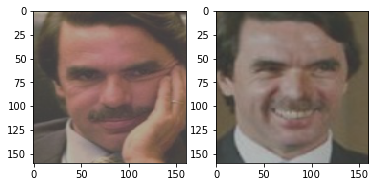

In [0]:
visualize_lfw_pair(0)

Different Person
Squared Euclidean Distance:  2.3449788  (threshold=0.99)


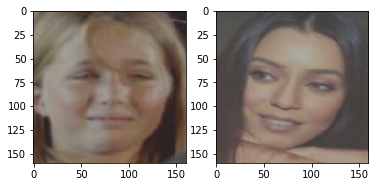

In [0]:
visualize_lfw_pair(3)

Attack Similar Pair (i = 0)

In [0]:
graph = tf.get_default_graph()
sess = tf.Session()

i = 0

model = InceptionResnetV1Model()
model.convert_to_targeted_classifier(victims_embeddings[i])
model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                          {phase_train_placeholder: False})
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")

attack = foolbox.v1.attacks.FGSM(model_fb)
adversarial = attack(faces1[i:i+1][0], label=0)

Model filename: ../models/20180402-114759/20180402-114759.pb


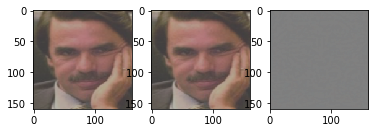

In [0]:
plt.subplot(1, 3, 1)
plt.imshow(faces1[i])

plt.subplot(1, 3, 2)
plt.imshow(adversarial)

plt.subplot(1, 3, 3)
plt.imshow(adversarial - faces1[i] + 0.5)

In [0]:
# Confirm this worked
# Remember class 0 is "same" and class 1 is "not same"
model_fb.forward(np.array([adversarial])).argmax(axis=-1)

array([1])

In [0]:
# How much of the face was changed
# squared euclidean distance (remember pixel values are scaled between 0-1 now)
np.linalg.norm(adversarial - faces1[i])

0.5438639794087756

Attack different pair

In [0]:
graph = tf.get_default_graph()
sess = tf.Session()

i = 3

model = InceptionResnetV1Model()
model.convert_to_targeted_classifier(victims_embeddings[i])
model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                          {phase_train_placeholder: False})
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")

attack = foolbox.v1.attacks.FGSM(model_fb)
adversarial = attack(faces1[i:i+1][0], label=1)

Model filename: ../models/20180402-114759/20180402-114759.pb


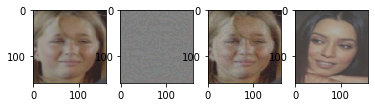

In [0]:
plt.subplot(1, 4, 1)
plt.imshow(faces1[i])

plt.subplot(1, 4, 2)
plt.imshow(adversarial - faces1[i] + 0.5)

plt.subplot(1, 4, 3)
plt.imshow(adversarial)

plt.subplot(1, 4, 4)
plt.imshow(faces2[i])

In [0]:
# Confirm this worked
# Remember class 0 is "same" and class 1 is "not same"
model_fb.forward(np.array([adversarial])).argmax(axis=-1)

array([0])

In [0]:
# How much of the face was changed
# squared euclidean distance (remember pixel values are scaled between 0-1 now)
np.linalg.norm(adversarial - faces1[i])

4.078979560652527

Compute aggregate attack statistics

In [0]:
%cd ..
%mkdir output
%cd src

from matplotlib.pyplot import imsave

/content


In [0]:
import time

binary_labels = [0 if labels[i][0] == 1 else 1 for i in range(size)]
changed = [None] * size
times = [None] * size
adversarials = [None] * size

graph = tf.get_default_graph()
sess = tf.Session()

model = InceptionResnetV1Model()
phase_train_placeholder = graph.get_tensor_by_name("phase_train:0")

Model filename: ../models/20180402-114759/20180402-114759.pb


In [1]:
for i in range(size):
  print("Starting to attack image ", i, " of ", size)
  model.convert_to_targeted_classifier(victims_embeddings[i])
  model_fb = foolbox.models.TensorFlowModel(model.face_input, model.logits, (0, 1),
                                            {phase_train_placeholder: False})

  attack = foolbox.v1.attacks.FGSM(model_fb)
  t0 = time.time()
  adversarial = attack(faces1[i:i+1][0], label=binary_labels[i])
  t1 = time.time()

  if (adversarial is not None):
    changed[i] = np.linalg.norm(adversarial - faces1[i])
    times[i] = t1 - t0
    adversarials[i] = adversarial